In [1]:
import numpy as np
import pandas as pd
import cupy as cp
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds, LinearOperator
import matplotlib.pyplot as plt
from tqdm import tqdm
from timeit import default_timer as timer

from dataprep import transform_indices , matrix_from_observations, to_numeric_id
from evaluation import topn_recommendations, model_evaluate, downvote_seen_items


# Loading ML1M dataset

In [2]:
training = pd.read_csv('data/ml-1m.train.rating', sep='\t', names=['userid', 'movieid', 'rating', 'timestamp'])
holdout = pd.read_csv('data/ml-1m.test.rating', sep='\t', names=['userid', 'movieid', 'rating', 'timestamp'])

In [3]:
negatives = {}
with open('data/ml-1m.test.negative', 'r') as fh:
    for line in fh:
        words = line.split()
        u, pos = eval(words[0])
        negatives[int(u)] = np.array([int(w) for w in words[1:]] + [pos])

In [4]:
data_description = dict(
    users = 'userid',
    items = 'movieid',
    feedback = 'rating',
    n_users = training['userid'].nunique(),
    n_items = training['movieid'].nunique(),
    test_users = holdout['userid'].values
)
data_description

{'users': 'userid',
 'items': 'movieid',
 'feedback': 'rating',
 'n_users': 6040,
 'n_items': 3704,
 'test_users': array([   0,    1,    2, ..., 6037, 6038, 6039])}

In [5]:
userid = data_description['users']
seen_idx_mask = training[userid].isin(data_description['test_users'])
testset = training[seen_idx_mask]

# Evaluation function

In [6]:
def score_and_evaluate(X, Y, training, data_description, topn=10, negatives=None):
    test_users = data_description['test_users']
    userid = data_description['users']
    testset = training.query(f'{userid} in @test_users')
    if negatives:
        recs = np.empty((len(test_users), topn), dtype=np.int32)
        for u, items in negatives.items():
            scores = X[u]@Y[items].T
            recs[u] = items[np.argsort(-scores)[:topn]]
    else:
        scores = X[test_users]@Y.T
        downvote_seen_items(scores, testset, data_description)
        recs = topn_recommendations(scores, topn=topn)
    metrics = model_evaluate(recs, holdout, data_description)
    return metrics

# Generate interaction matrix

In [7]:
mtx = matrix_from_observations(training, data_description)
mtx_gpu = cp.sparse.csr_matrix(mtx)


# Baseline code: ALS of sparse matrix

In [8]:
def sparse_als_epoch(X, Y, Rx, Ry, E, ridx, rptr, cidx, cptr, reg, alpha):
    xp = cp.get_array_module(X)
    YtY = Y.T @ Y 
    for i in range(X.shape[0]):
        Y_ = Y[ridx[rptr[i]:rptr[i+1]]]
        lhs = alpha * YtY + Y_.T @ Y_ + reg * Rx[i] * E  
        rhs = Y_.sum(axis=0)                                   
        X[i] = xp.linalg.solve(lhs, rhs)

    XtX = X.T @ X
    for j in range(Y.shape[0]):
        X_ = X[cidx[cptr[j]:cptr[j+1]]]
        lhs = alpha * XtX + X_.T @ X_ + reg * Ry[j] * E 
        rhs = X_.sum(axis=0)
        Y[j] = xp.linalg.solve(lhs, rhs)
    
    return X, Y

In [9]:
def als(P_csr, params: dict, epoch_fcn=sparse_als_epoch) -> tuple:   
    global training, data_description, negatives

    xp = cp.get_array_module(P_csr)
    
    history = {}
    history['Time'] = []
    history['HR'] = []
    
    P_csc = P_csr.tocsc()
    nU, nI = P_csr.shape

    epochs = params.get('epochs', 5)
    istd = params.get('istd', 0.1)
    rank = params.get('rank', min(nU, nI) // 10 + 1)
    
    reg = params.get('reg', 0.1)
    alpha = params.get('alpha', 0.2)
    v = params.get('v', 1)

    std = istd / np.sqrt(rank)
    
    Y = xp.random.randn(nI, rank) * std
    X = xp.random.randn(nU, rank) * std
    E = xp.eye(rank)

    #rdata = P_csr.data  # implicit feedback, no ratings, 
    ridx = P_csr.indices
    rptr = P_csr.indptr
    Rx = (xp.diff(rptr) + alpha * nI) ** v          #(I(u)+alpha*I0)^v
    
    #cdata = P_csc.data ** 0 # implicit feedback, no ratings, 
    cidx = P_csc.indices
    cptr = P_csc.indptr
    Ry = (xp.diff(cptr) + alpha * nU) ** v          #(U(i)+alpha*U0)^v
    
    if xp.__name__=='cupy':
        X_, Y_ = X.get(), Y.get()
    else:
        X_, Y_ = X, Y
    rnd_hr = score_and_evaluate(X_, Y_, training, data_description, negatives=negatives, topn=10)[0]

    print(f'Epoch {0}:\tHR={rnd_hr:.4f}')
    for e in range(epochs):
        start = timer()
        X, Y = epoch_fcn(X, Y, Rx, Ry, E, ridx, rptr, cidx, cptr, reg, alpha)
        end = timer()
        
        history['Time'].append(end-start)
        if xp.__name__=='cupy':
            X_, Y_ = X.get(), Y.get()
        else:
            X_, Y_ = X, Y
        history['HR'].append(score_and_evaluate(X_, Y_, training, data_description, negatives=negatives, topn=10)[0])
        print(f'Epoch {e+1}:\tHR={history["HR"][-1]:.4f}, time={history["Time"][-1]:.2f}')
    return X, Y, history


In [10]:
params = dict(
    epochs = 4,
    istd = 0.1,
    rank = 128,
    reg = 0.007,
    alpha = 0.3,
    v = 1
)

In [11]:
params['rank'] = 128
params['epochs'] = 3
X, Y, history = als(mtx, params, epoch_fcn=sparse_als_epoch)

Epoch 0:	HR=0.0970
Epoch 1:	HR=0.5210, time=2.12
Epoch 2:	HR=0.6896, time=2.13
Epoch 3:	HR=0.7200, time=2.12


# Joblib

In [12]:
from joblib import Parallel, delayed
def joblib_als_epoch(njobs=-1):
    def solve(k ,Z, ZtZ, R, idx, ptr, reg, alpha, E):
        Z_ = Z[idx[ptr[k]:ptr[k+1]]]
        lhs = alpha * ZtZ + Z_.T @ Z_ + reg * R[k] * E  
        rhs = Z_.sum(axis=0)                                   
        return np.linalg.solve(lhs, rhs)

    def joblib_als_epoch_(X, Y, Rx, Ry, E, ridx, rptr, cidx, cptr, reg, alpha):
        xp = cp.get_array_module(X)
        YtY = Y.T @ Y  
        X = xp.vstack(Parallel(n_jobs=njobs)(
            delayed(solve) (i, Y, YtY, Rx, ridx, rptr, reg, alpha, E) for i in range(X.shape[0])))
        XtX = X.T @ X
        Y= xp.vstack(Parallel(n_jobs=njobs)(
            delayed(solve) (j, X, XtX, Ry, cidx, cptr, reg, alpha, E) for j in range(Y.shape[0])))
        
        return X, Y   
    return joblib_als_epoch_

In [13]:
X, Y, history = als(mtx, params, epoch_fcn=joblib_als_epoch(njobs=12))

Epoch 0:	HR=0.0950
Epoch 1:	HR=0.5321, time=2.13
Epoch 2:	HR=0.6925, time=1.42
Epoch 3:	HR=0.7225, time=1.41


# Concurrent

In [14]:
from concurrent import futures

def solve(k ,Z, ZtZ, R, idx, ptr, reg, alpha, E):
    xp = cp.get_array_module(Z)
    Z_ = Z[idx[ptr[k]:ptr[k+1]]]
    lhs = alpha * ZtZ + np.dot(Z_.T, Z_) + reg * R[k] * E  
    rhs = Z_.sum(axis=0)                                   
    return xp.linalg.solve(lhs, rhs)

def concurrent_als_epoch(njobs=1):
    def concurrent_als_epoch_(X, Y, Rx, Ry, E, ridx, rptr, cidx, cptr, reg, alpha):
        YtY = Y.T @ Y 
        with futures.ThreadPoolExecutor(max_workers=njobs) as executor:
            results = {executor.submit(solve, i , Y, YtY, Rx, ridx, rptr, reg, alpha, E): i for i in range(X.shape[0])}
            for future in futures.as_completed(results):
                i = results[future]
                X[i] = future.result()

        XtX = X.T @ X
        with futures.ThreadPoolExecutor(max_workers=njobs) as executor:
            results = {executor.submit(solve, j, X, XtX, Ry, cidx, cptr, reg, alpha, E): j for j in range(Y.shape[0])}
            for future in futures.as_completed(results):
                i = results[future]
                Y[i] = future.result()
        return X, Y
    
    return concurrent_als_epoch_

In [15]:
X, Y, history = als(mtx, params, epoch_fcn=concurrent_als_epoch(njobs=4))

Epoch 0:	HR=0.1012
Epoch 1:	HR=0.5141, time=3.49
Epoch 2:	HR=0.6939, time=3.43
Epoch 3:	HR=0.7224, time=3.78


# Numba `@jit`

In [30]:
from numba import jit, prange
@jit(nopython=True, nogil=True, fastmath=True)
def solve_jit(k ,Z, ZtZ, R, idx, ptr, reg, alpha, E):
    Z_ = Z[idx[ptr[k]:ptr[k+1]]]
    lhs = alpha * ZtZ + Z_.T @ Z_ + reg * R[k] * E  
    rhs = Z_.sum(axis=0)                                   
    return np.linalg.solve(lhs, rhs)

@jit(nopython=True, nogil=True, fastmath=True)
def jit_als_epoch(X, Y, Rx, Ry, E, ridx, rptr, cidx, cptr, reg, alpha):
    YtY = Y.T @ Y
    for i in range(X.shape[0]):
        X[i] = solve_jit( i , Y, YtY, Rx, ridx, rptr, reg, alpha, E)

    XtX = X.T @ X
    for j in range(Y.shape[0]):
        Y[j] = solve_jit(j, X, XtX, Ry, cidx, cptr, reg, alpha, E)

    return X, Y

In [18]:
X, Y, history = als(mtx_gpu, params, epoch_fcn=sparse_als_epoch)

Epoch 0:	HR=0.0919
Epoch 1:	HR=0.5184, time=7.61
Epoch 2:	HR=0.6904, time=7.42
Epoch 3:	HR=0.7179, time=7.17


# Composing experiments

In [19]:
experiments = [
    #name    #data    #epoch_fcn 
    ('Standard Sparse'    , mtx    , sparse_als_epoch       ),  
    ('Joblib njobs=1'     , mtx    , joblib_als_epoch(1)    ),  
    ('Joblib njobs=4'     , mtx    , joblib_als_epoch(4)    ),  
    ('Joblib njobs=8'     , mtx    , joblib_als_epoch(8)    ),  
    ('Joblib njobs=12'    , mtx    , joblib_als_epoch(12)   ),  
    ('Concurrent njobs=1' , mtx    , concurrent_als_epoch(1)),  
    ('Concurrent njobs=4' , mtx    , concurrent_als_epoch(4)),   
    ('Jit'                , mtx    , jit_als_epoch          ),  
    ('Standard Sparse GPU', mtx_gpu, sparse_als_epoch       ), 
]
params = dict(
    epochs = 4,
    istd = 0.1,
    rank = 128,
    reg = 0.007,
    alpha = 0.3,
    v = 1
)

In [25]:
import json

TRAIN = False

ranks= [32, 64, 128, 256 ,512]
if TRAIN:
    params['epochs'] = 8
    results = {}
    for exp_name, data, epoch_fcn in experiments: 
        results[exp_name] = {}
        for r in ranks:
            print(f'{exp_name}\trank={r}')
            params['rank'] = r
            _, _, history = als(data, params, epoch_fcn)
            results[exp_name][r] = history
    json.dump(results, open('results.json', 'w'), indent=4)
else:
    results = json.load(open('results.json', 'r'))

In [26]:
def center(seq):
    seq = np.array(seq)
    return seq.mean(axis=1)

def upper(seq):
    seq = np.array(seq)
    return seq.mean(axis=1) + 2 * seq.std(axis=1)

def lower(seq):
    seq = np.array(seq)
    return seq.mean(axis=1) - 2 * seq.std(axis=1)

# Reading iALS (Rendle 2021) results
These benchmarks were recorded for the code available in [https://github.com/google-research/google-research/tree/master/ials/]. I stored results separately as they take too long and they run using python2.

In [27]:
import glob
import re
baseline_times = []
baseline_ranks = []
for path in glob.glob('baseline_logs/iALS*.json'):
    rank = int(re.findall('baseline_logs/iALS(\d+).json', path)[0])
    baseline_ranks.append(rank)
    baseline_times.append(json.load(open(path))['Time'][:10])
ranks_times = zip(*sorted(zip(baseline_ranks, baseline_times)))
baseline_ranks, baseline_times = list(next(ranks_times)), list(next(ranks_times)) 

# Final Plot

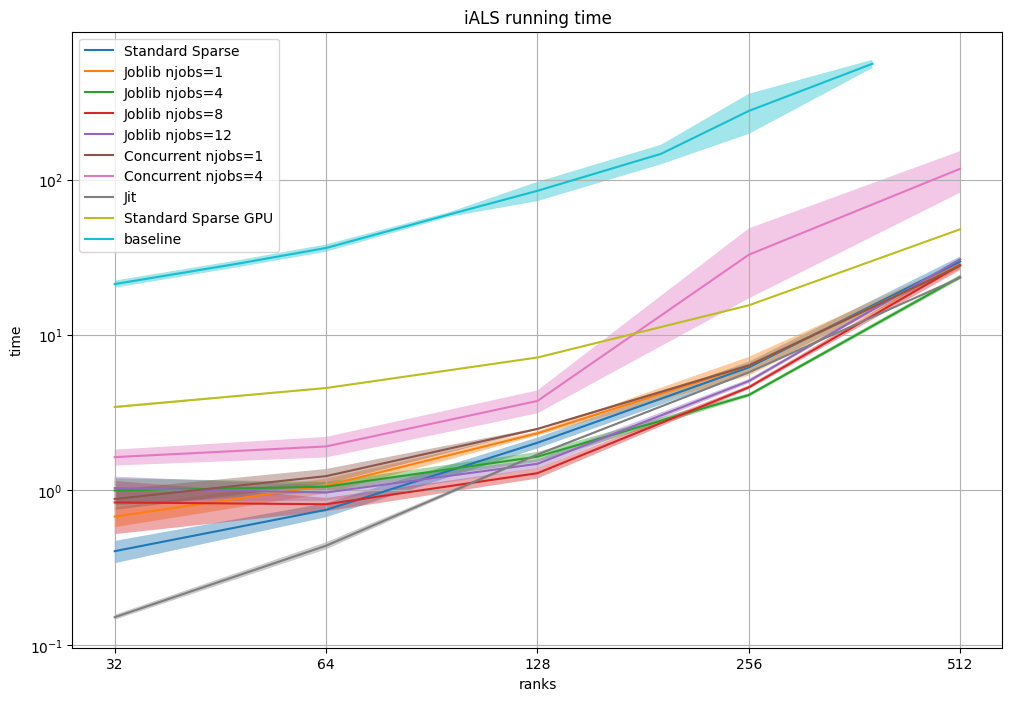

In [28]:
from matplotlib.ticker import ScalarFormatter

fig, ax = plt.subplots(figsize=(12,8))

for exp_name in results:
    times = []
    for rank in results[exp_name]:
        T = results[exp_name][rank]['Time']
        if exp_name == 'Jit':
            T.pop(0) #exclude compilation epoch
        times.append(T)
    ax.plot(ranks, center(times), label=exp_name)
    ax.fill_between(ranks, lower(times), upper(times), alpha = 0.4)

ax.plot(baseline_ranks, center(baseline_times), label='baseline')
ax.fill_between(baseline_ranks, lower(baseline_times), upper(baseline_times), alpha = 0.4)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xticks(ranks)
ax.minorticks_off()
ax.get_xaxis().set_major_formatter(ScalarFormatter())
ax.set_xlabel('ranks')
ax.set_ylabel('time')
ax.set_title('iALS running time')
ax.grid(True, which="both")
ax.legend();